 Imports

In [94]:
import numpy as np
import pandas as pd
import genData
import matplotlib as mpl
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

%matplotlib inline

Load our data sets for consistant and reproducible results

In [95]:
plt.style.use("seaborn")
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

In [96]:
seed = 637120123
testDataSeed = 781264812
genData.def_seed = seed

In [97]:
trainA = genData.create_A()
testA = genData.create_A(seed=testDataSeed)
trainA

,x,y,target
0,30.82,35.11,1
1,88.38,-90.20,-1
2,34.61,-38.24,-1
3,-71.51,-59.71,-1
4,-73.85,57.25,1
...,...,...,...
995,-93.37,22.69,1
996,73.80,95.16,1
997,-58.18,63.26,1
998,-92.76,-41.66,-1


## Adaline Model

In [313]:
class Adaline:
    def __init__(self,seed:int = None, learning_rate:float=0.00001, bias:float=0.2, repeats:int=10000, possible_targets=None,epsilon=0.00000001, activationFunction=lambda x: 1 if x>= 0 else -1):
        self.rng = np.random.RandomState(seed)
        self.repeats = repeats
        self.learning_rate = learning_rate
        self.bias = bias
        self.possible_targets = possible_targets
        self.epsilon = epsilon
        self.activationFunction = activationFunction
        
    def calc(self,sample):
        return self.bias + np.dot(self.weights,sample)

    def fit(self,data,target,verbose:int=0,precision:int=4,max_step:int=10,logRate:int=5) -> dict:
        
        #make sure we are using a numpy array of shape (fetures, samples)
        if isinstance(data,pd.DataFrame):
            data = data.to_numpy().T
            
        self.weights = self.rng.rand(data.shape[0])
        
        #logging
        past_MSE = [float("inf")]

        #save each epoch
        stats = {"Epoch":[],"bias":[],"MSE":[]}
        for feature_i in range(data.shape[0]):
            stats["w_"+str(feature_i)] = []
            stats["deltaW_"+str(feature_i)] = []
        
        #make sure we don't enter an infinite loop if our model doesn't converge
        for i in range(self.repeats):
            errors = []
            
            #repeat for all data samples
            for x_i in range(data.shape[1]):
                #sum(w_i*x_i) for all features 
                Y = self.calc(data[:,x_i])
                
                pred = 0
                pred = self.activationFunction(Y)

                delta = 0
                #adjust weights and bias if we guessed wrong
                if pred != target[x_i]:
                    delta = (target[x_i]-Y)
                    deltaW = self.learning_rate*delta*data[:,x_i]
                   
                    self.weights = self.weights + deltaW
                    self.bias = self.bias+self.learning_rate*delta
                    
                #squared error 
                errors.append((delta**2))
                
                
            if len(errors) == 0:
                break
            mse = sum(errors)/len(errors)
            past_MSE.append(mse)

            if i%logRate == 0:
                #save stats of each value in our data
                stats["bias"].append(round(self.bias,precision))
                stats["MSE"].append(round(mse,precision))
                stats["Epoch"].append(i)
                for feature_i in range(data.shape[0]):
                    stats["w_"+str(feature_i)].append(round(self.weights[feature_i],precision))
                    stats["deltaW_"+str(feature_i)].append(round(deltaW[feature_i],precision))
            
            #print stats
            if verbose>=1 and i%logRate == 0:
                print("Epoch",i)
                print(mse)
                print("errors:",len([err for err in errors if err>0]))
                if verbose>=2:
                    df = pd.DataFrame(stats)
                    print(df)
                print("--------")

            #stop if our mse is not changing at all
            if len(past_MSE) > max_step and (all(abs(past_MSE[-1] - x)<self.epsilon for x in past_MSE[-max_step:]) or np.all(np.diff( np.array(past_MSE[-max_step:])) >= 0)):
                break
        
        model_performance = pd.DataFrame(stats)
        return model_performance


    def predict(self,data):
        #make sure we are using a numpy array of shape (fetures, samples)
        if isinstance(data,pd.DataFrame):
            data = data.to_numpy().T
        
        #get vector of predicted target values
        target = []
        for x_i in range(data.shape[1]):
            target.append(self.activationFunction(self.calc(data[:,x_i])))
        return np.array(target)
    
    #simple plot
    def plot_graph(self,data,args1={},args2={},ax:plt.Axes=None,Vmin=-100,Vmax=101,precision=1,name=None):
        #keep precision positive
        if precision<0:
            precision*=-1
        if ax == None:
            ax = plt.gca()
        if isinstance(data,pd.DataFrame):
            data = data.to_numpy().T
        x_vals = np.arange(Vmin,Vmax)
        yMax_vals = []
        yMin_vals = []
        #get min and max values of y for each x
        for x in x_vals:
            yMax_vals.append(None)
            yMin_vals.append(None)
            for y in range(Vmin,Vmax,precision):
                val = self.calc(np.array([x,y]))
                if self.activationFunction(val) == 1 and yMin_vals[-1] == None:
                    yMin_vals[-1]=y
                if self.activationFunction(val) == 1:
                    yMax_vals[-1]=y
            
        if yMax_vals[0] == None:
            try:
                yMax_vals[0] = next(v for v in yMax_vals if v != None)
            except:
                yMax_vals[0] = Vmax
        if yMin_vals[0] == None:
            try:
                yMin_vals[0] = next(v for v in yMin_vals if v != None)
            except:
                yMin_vals[0] = Vmax
        
        for i in range(1,len(yMax_vals)):
            if yMin_vals[i] == None:
                yMin_vals[i] = yMin_vals[i-1]
            if yMax_vals[i] == None:
                yMax_vals[i] = yMax_vals[i-1]

        #get the color in args if exits
        color1 = "r"
        color2 = "b"
        if "c" in args1:
            color1 = args1["c"]
        if "c" in args2:
            color2 = args2["c"]
        #our predictions of the data
        predictions = self.predict(data)
        targets_pos = data[:,np.argwhere(predictions == 1)].T[0].T
        targets_neg = data[:,np.argwhere(predictions == -1)].T[0].T
        
        #data points
        ax.scatter(targets_pos[0], targets_pos[1], **args1)
        ax.scatter(targets_neg[0], targets_neg[1], **args2)
        #area of classification
        ax.fill_between(x_vals,np.ones(Vmax-Vmin)*Vmin,y2=yMin_vals, alpha=0.3, color=color2)
        ax.fill_between(x_vals,np.ones(Vmax-Vmin)*Vmax,y2=yMax_vals, alpha=0.3, color=color2)
        ax.fill_between(x_vals,yMax_vals,y2=yMin_vals, alpha=0.3, color=color1)
        #classification area
        ax.plot(x_vals,yMax_vals,c="y")
        ax.plot(x_vals,yMin_vals,c="g")
        ax.legend()
        if name != None:
            plt.savefig(name)
    

In [314]:
def plot_performance(performance,name=None):
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(16,16))
    ax1.plot(performance["Epoch"],performance["MSE"])
    ax1.set_title("model MSE")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("MSE")

    ax2.plot(performance["Epoch"],performance["bias"])
    ax2.set_title("model bias")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("bias")

    ax3.plot(performance["Epoch"],performance["w_0"])
    ax3.set_title("model x weight")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("weight")

    ax4.plot(performance["Epoch"],performance["w_1"])
    ax4.set_title("model y weight")
    ax4.set_xlabel("Epoch")
    ax4.set_ylabel("weight")
    if name != None:
        plt.savefig(name)

## Part A

In [315]:
ad = Adaline(seed, bias=0.1,learning_rate=0.0001)
performance = ad.fit(trainA.loc[:,["x","y"]],trainA["target"],verbose=1, logRate = 10)

Epoch 0
2.6683190620834076
errors: 14
--------
Epoch 10
0.02089836842632647
errors: 6
--------
Epoch 20
0.020550389051494557
errors: 6
--------
Epoch 30
0.02020820000783398
errors: 6
--------
Epoch 40
0.0198717051855464
errors: 6
--------
Epoch 50
0.01954081006786673
errors: 6
--------
Epoch 60
0.019215421704677674
errors: 6
--------
Epoch 70
0.01889544868656132
errors: 6
--------
Epoch 80
0.01858080111928019
errors: 6
--------
Epoch 90
0.018271390598680874
errors: 6
--------
Epoch 100
0.017967130186013227
errors: 6
--------
Epoch 110
0.01766793438365804
errors: 6
--------
Epoch 120
0.01737371911125678
errors: 6
--------
Epoch 130
0.017084401682236437
errors: 6
--------
Epoch 140
0.01679990078072304
errors: 6
--------
Epoch 150
0.016520136438837513
errors: 6
--------
Epoch 160
0.016245030014367303
errors: 6
--------
Epoch 170
0.01597450416880785
errors: 6
--------
Epoch 180
0.015708482845767507
errors: 6
--------
Epoch 190
0.015446891249730097
errors: 6
--------
Epoch 200
0.01518965582

In [316]:
performance.tail(3)

,Epoch,bias,MSE,w_0,deltaW_0,w_1,deltaW_1
119,1190,-0.5961,0.002,-0.0041,-0.0038,0.7115,-0.0001
120,1200,-0.5974,0.001,-0.0015,0.0003,0.7105,-0.0001
121,1210,-0.5985,0.000,-0.0009,0.0003,0.7095,-0.0001


### Model preformance

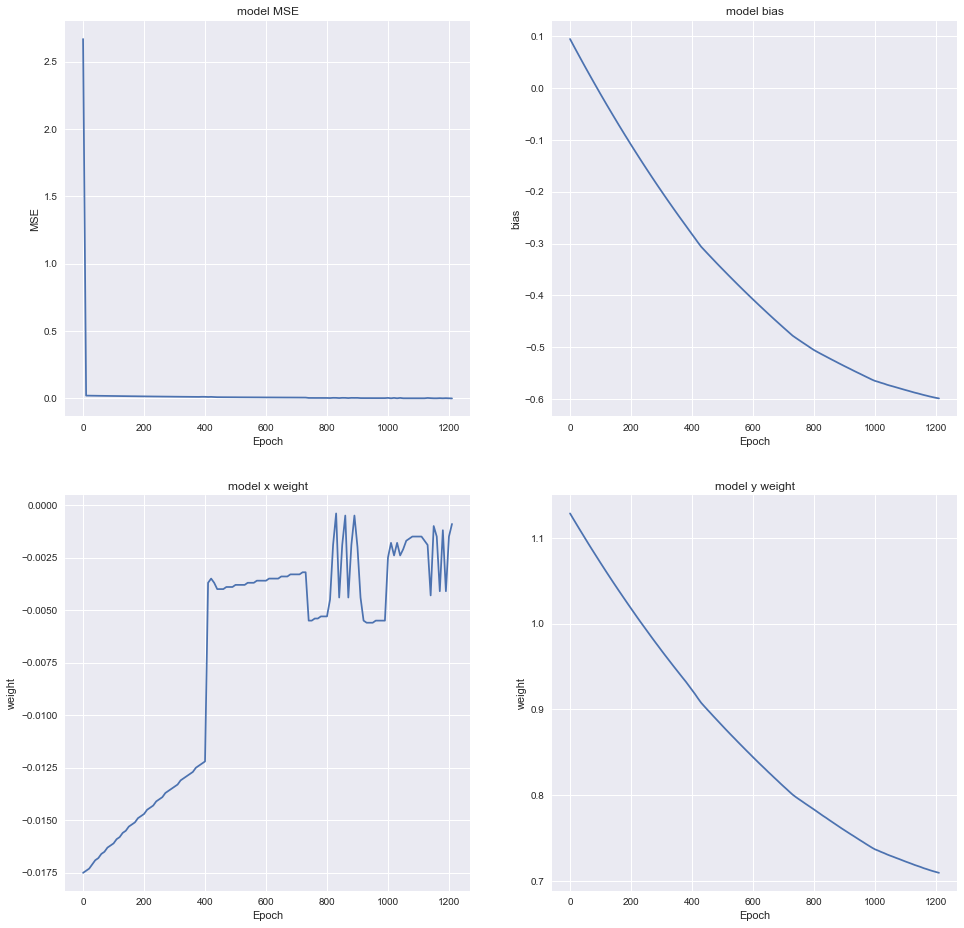

In [317]:
plot_performance(performance=performance,name="partA_stats")

We can clearly see that our model understands that the x value doesn't matter and so, the weight of the paramater is aproaching 0

In [412]:
ad.weights,ad.bias

(array([-0.00086618,  0.70954654]), -0.5985327512240897)

In [411]:
testA_res = ad.predict(testA.loc[:,["x","y"]])
accuracy_score(testA["target"],testA_res)

1.0

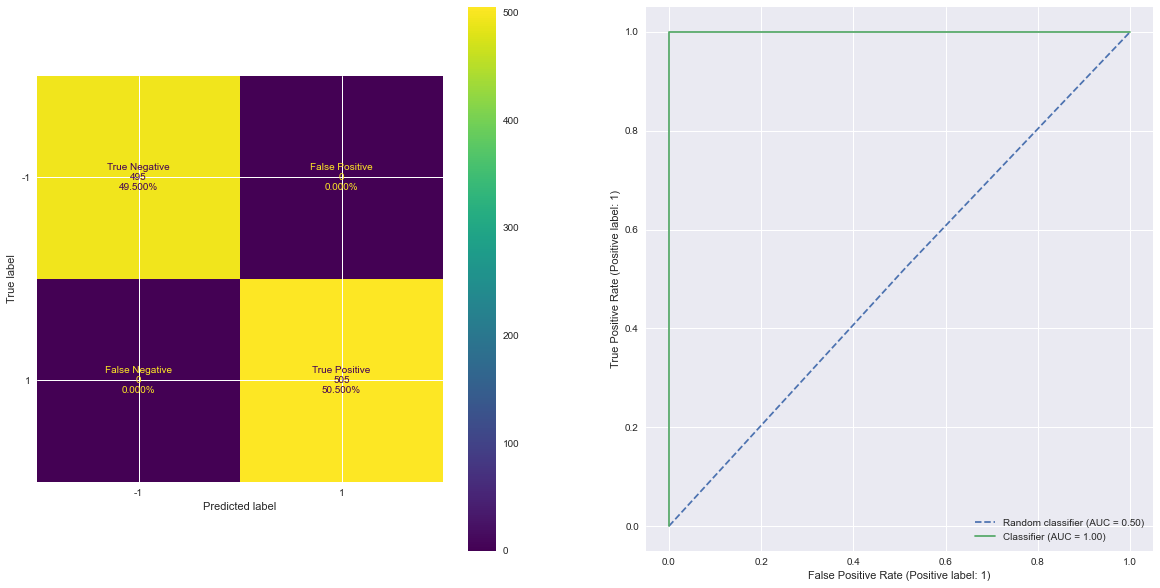

In [319]:
genData.plot_model_results(testA["target"],testA_res,labels=["-1","1"],name="partA_cm_roc")

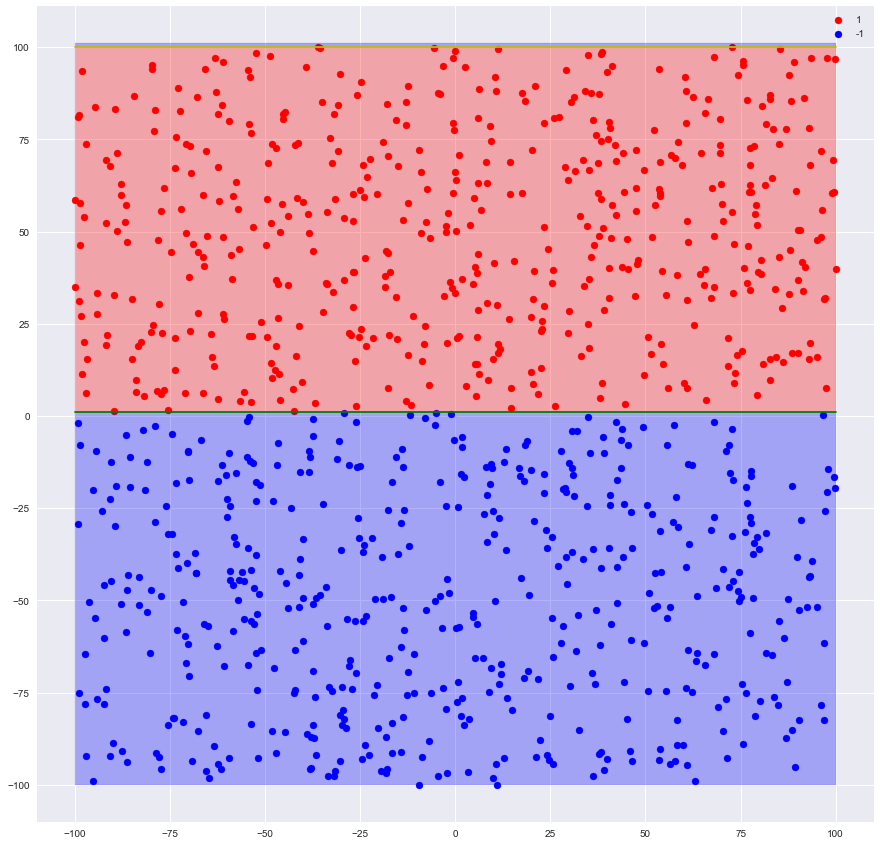

In [320]:
plt.figure(figsize=(15,15))
ad.plot_graph(data=testA.loc[:,["x","y"]],args1={"c":'r',"label":"1"},args2={"c":'b',"label":"-1"},name="partA_graph")

## Part B

In [321]:
trainB = genData.create_B(size=1000)
testB = genData.create_B(seed=testDataSeed,size=1000)
#make sure sets have atleast one point with target = 1
train_extra = {"x":[],"y":[],"target":[]}
test_extra = {"x":[],"y":[],"target":[]}


while len(train_extra["target"]) < 1 or len(test_extra["target"])<1:
    train_x = np.random.randint(-300,301)
    train_y = np.random.randint(-300,301)
    test_x = np.random.randint(-300,301)
    test_y = np.random.randint(-300,301)
    
    if 40000 <= train_x**2 + train_y**2 and train_x**2 + train_y**2 <= 90000:
        train_extra["x"].append(train_x/100)
        train_extra["y"].append(train_y/100)
        train_extra["target"].append(1)
    if 40000 <= test_x**2 + test_y**2 and test_x**2 + test_y**2 <= 90000:
        test_extra["x"].append(test_x/100)
        test_extra["y"].append(test_y/100)
        test_extra["target"].append(1)

train_extra = pd.DataFrame(train_extra)
trainB = trainB.append(train_extra,ignore_index=True).sample(frac=1).reset_index(drop=True)

test_extra = pd.DataFrame(test_extra)
testB = testB.append(test_extra,ignore_index=True)


trainB

,x,y,target
0,99.38,-72.01,-1
1,62.50,63.56,-1
2,84.89,-71.98,-1
3,15.38,2.00,-1
4,-57.00,45.87,-1
...,...,...,...
996,-0.56,-39.25,-1
997,-80.29,-74.34,-1
998,-48.56,96.90,-1
999,-55.93,-74.53,-1


In [322]:
activationFunction = lambda x: 1 if abs(x) <=1 else -1
ad2 = Adaline(seed,bias=0,learning_rate=0.000025,repeats=1000,activationFunction=activationFunction)
performance2 = ad2.fit(trainB.loc[:,["x","y"]], trainB["target"], logRate = 10,verbose=1,precision=10)

Epoch 0
0.02198139371454821
errors: 10
--------
Epoch 10
0.02062210892324726
errors: 9
--------
Epoch 20
0.02058879113349432
errors: 9
--------
Epoch 30
0.02055553354688311
errors: 9
--------
Epoch 40
0.020522336035912764
errors: 9
--------
Epoch 50
0.020489198473834087
errors: 9
--------
Epoch 60
0.020456120734261958
errors: 9
--------
Epoch 70
0.020423102691175143
errors: 9
--------
Epoch 80
0.020390144218913244
errors: 9
--------
Epoch 90
0.02035724519217648
errors: 9
--------
Epoch 100
0.02032440548602361
errors: 9
--------
Epoch 110
0.02029162497587052
errors: 9
--------
Epoch 120
0.020258903537489065
errors: 9
--------
Epoch 130
0.02022624104700528
errors: 9
--------
Epoch 140
0.02019363738089821
errors: 9
--------
Epoch 150
0.02016109241599837
errors: 9
--------
Epoch 160
0.020128606029486348
errors: 9
--------
Epoch 170
0.020096178098890978
errors: 9
--------
Epoch 180
0.020063808502089078
errors: 9
--------
Epoch 190
0.02003149711730264
errors: 9
--------
Epoch 200
0.019999243

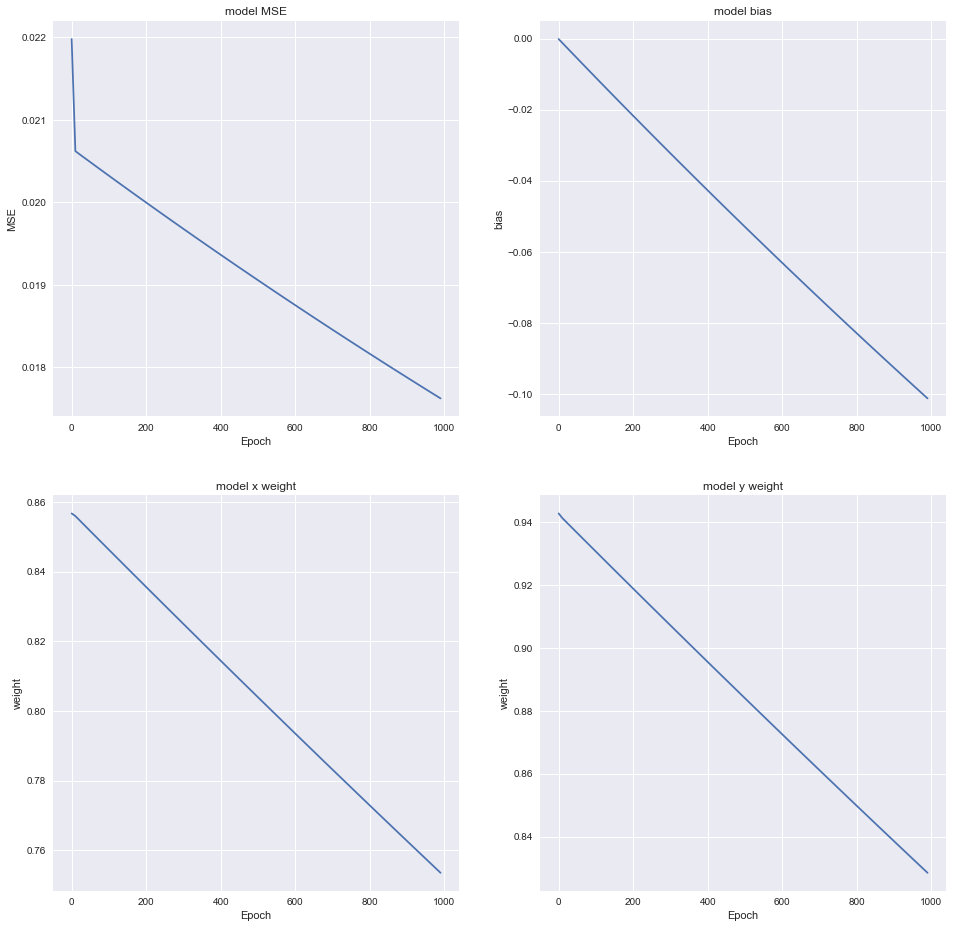

In [323]:
plot_performance(performance=performance2,name="partB_stats")

In [324]:
testB_res = ad2.predict(testB.loc[:,["x","y"]])
accuracy_score(testB["target"],testB_res)

0.985014985014985

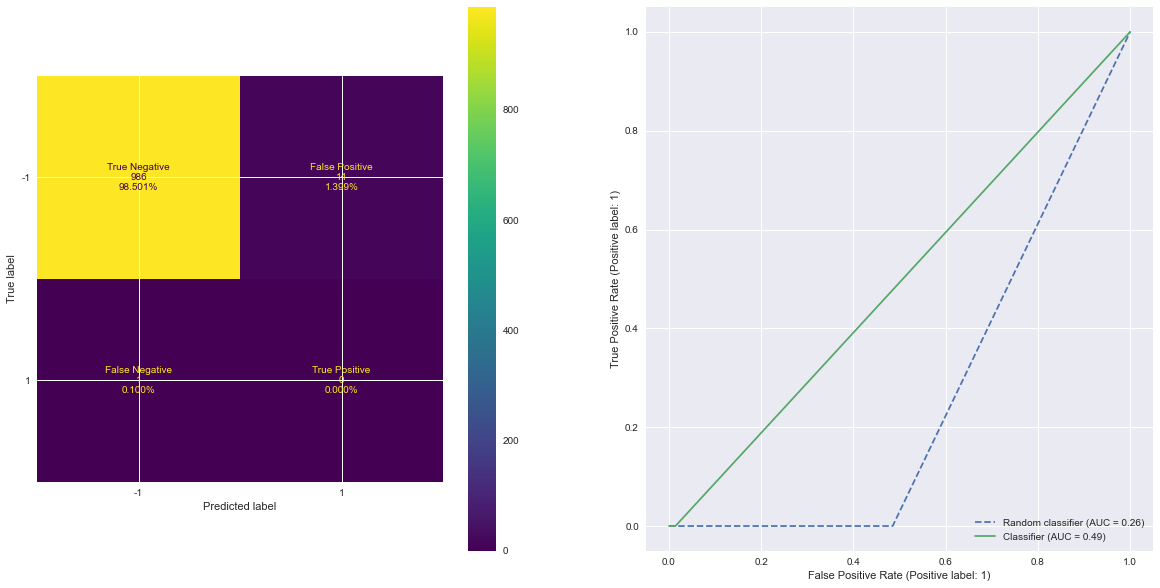

In [325]:
genData.plot_model_results(testB["target"],testB_res,labels=["-1","1"],name="partB_cm_roc")

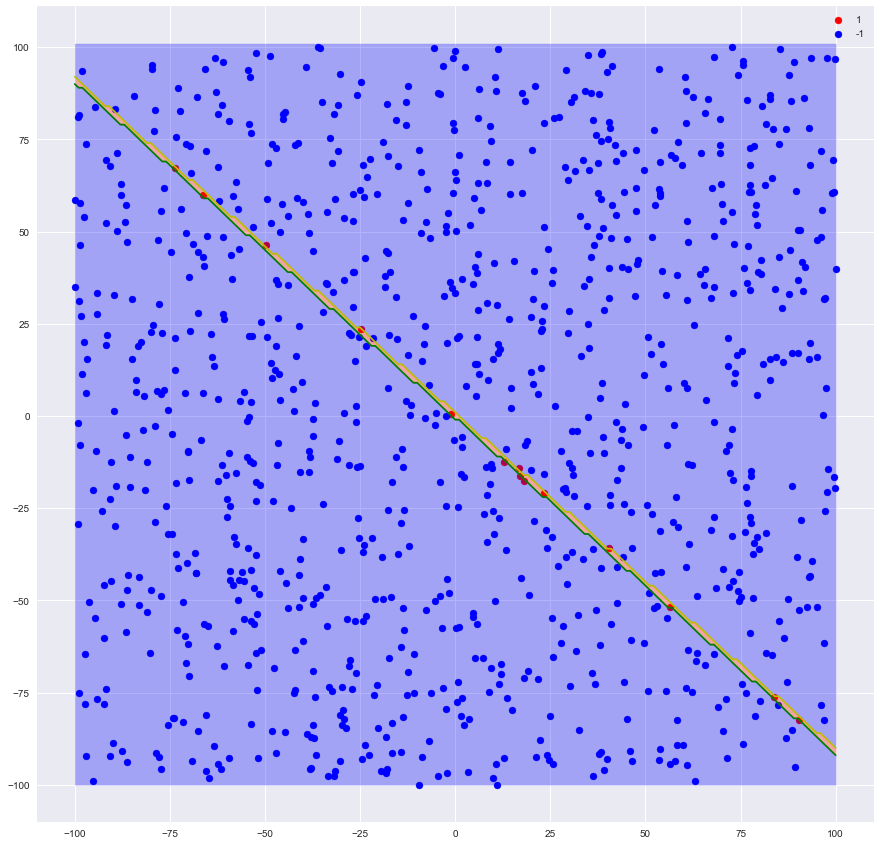

In [326]:
plt.figure(figsize=(15,15))
ad2.plot_graph(data=testB.loc[:,["x","y"]],args1={"c":'r',"label":"1"},args2={"c":'b',"label":"-1"},name="partB_graph")

In [362]:
trainB = genData.create_B(size=1000)
testB = genData.create_B(seed=testDataSeed,size=1000)

train_extra = {"x":[],"y":[],"target":[]}
test_extra = {"x":[],"y":[],"target":[]}


while len(train_extra["target"]) < 30 or len(test_extra["target"])<30:
    train_x = np.random.randint(-300,301)
    train_y = np.random.randint(-300,301)
    test_x = np.random.randint(-300,301)
    test_y = np.random.randint(-300,301)
    
    if 40000 <= train_x**2 + train_y**2 and train_x**2 + train_y**2 <= 90000:
        train_extra["x"].append(train_x/100)
        train_extra["y"].append(train_y/100)
        train_extra["target"].append(1)
    if 40000 <= test_x**2 + test_y**2 and test_x**2 + test_y**2 <= 90000:
        test_extra["x"].append(test_x/100)
        test_extra["y"].append(test_y/100)
        test_extra["target"].append(1)

train_extra = pd.DataFrame(train_extra)
trainB = trainB.append(train_extra,ignore_index=True).sample(frac=1).reset_index(drop=True)

test_extra = pd.DataFrame(test_extra)
testB = testB.append(test_extra,ignore_index=True)

trainB


,x,y,target
0,34.47,-5.70,-1
1,-53.11,52.24,-1
2,-28.72,-14.52,-1
3,-78.30,28.39,-1
4,-20.45,-27.76,-1
...,...,...,...
1025,-51.09,-85.47,-1
1026,44.65,-6.80,-1
1027,-57.80,-54.94,-1
1028,50.64,-72.23,-1


In [363]:

ad2 = Adaline(seed,bias=0.35,learning_rate=0.000025,repeats=1000,activationFunction=activationFunction)
performance2 = ad2.fit(trainB.loc[:,["x","y"]], trainB["target"], logRate = 10,verbose=1,precision=10)

Epoch 0
0.15066233473600849
errors: 34
--------
Epoch 10
0.14518484273186474
errors: 34
--------
Epoch 20
0.13990315584845467
errors: 34
--------
Epoch 30
0.13486342031668583
errors: 35
--------
Epoch 40
0.13005632777283416
errors: 36
--------
Epoch 50
0.1254810986650099
errors: 36
--------
Epoch 60
0.11740459542609309
errors: 35
--------
Epoch 70
0.11344203348198181
errors: 35
--------
Epoch 80
0.10966427132588805
errors: 36
--------
Epoch 90
0.10606878050112446
errors: 35
--------
Epoch 100
0.10264209724034834
errors: 35
--------
Epoch 110
0.09937627313458691
errors: 36
--------
Epoch 120
0.09610643069348937
errors: 34
--------
Epoch 130
0.0892580577662207
errors: 34
--------
Epoch 140
0.08655174429912636
errors: 34
--------
Epoch 150
0.0801374051420878
errors: 33
--------
Epoch 160
0.07785048125554667
errors: 33
--------
Epoch 170
0.07183167727170846
errors: 32
--------
Epoch 180
0.06990930715338518
errors: 32
--------
Epoch 190
0.06807194918785366
errors: 32
--------
Epoch 200
0.06

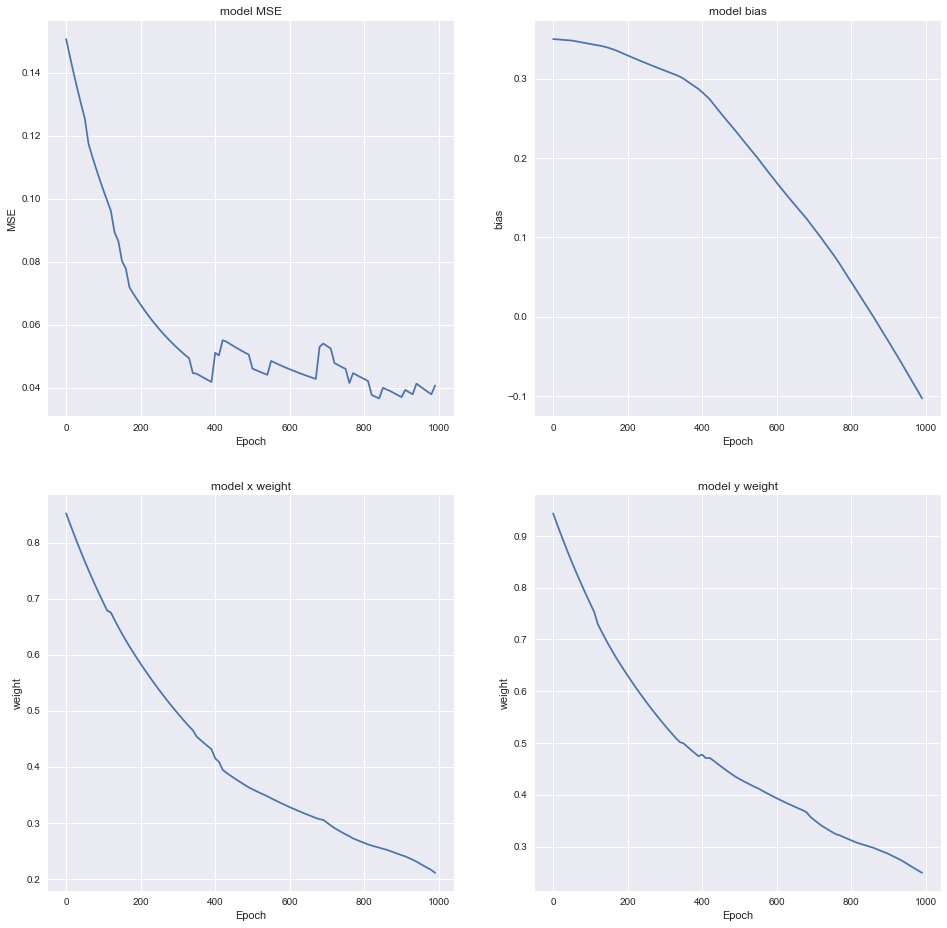

In [364]:
plot_performance(performance=performance2,name="partB_balanced_stats")

In [365]:
testB_res = ad2.predict(testB.loc[:,["x","y"]])
accuracy_score(testB["target"],testB_res)

0.9623552123552124

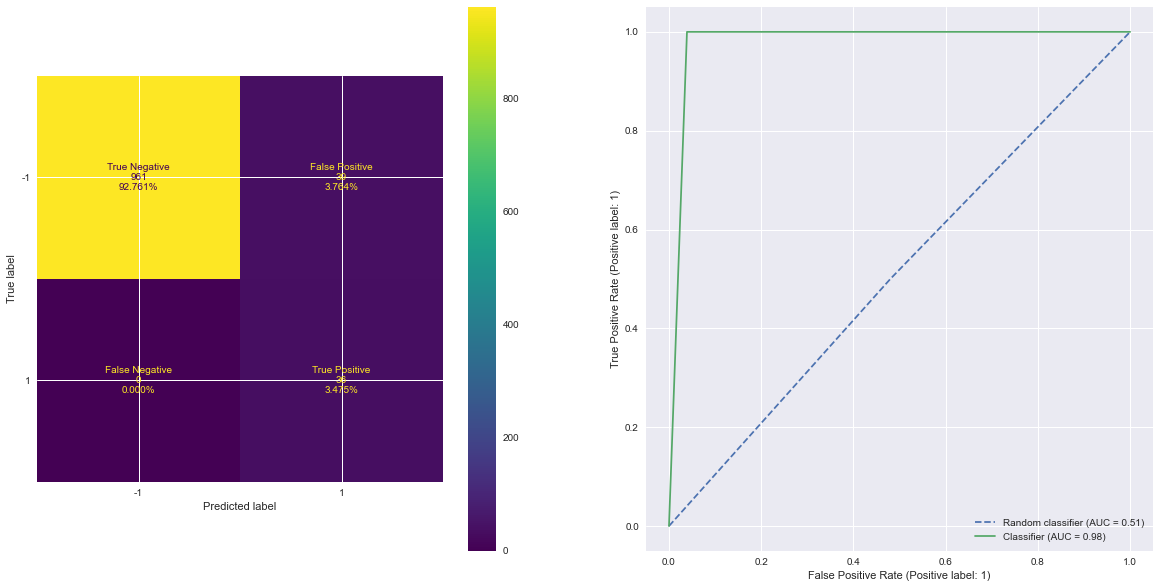

In [366]:
genData.plot_model_results(testB["target"],testB_res,labels=["-1","1"],name="partB_balanced_cm_roc")

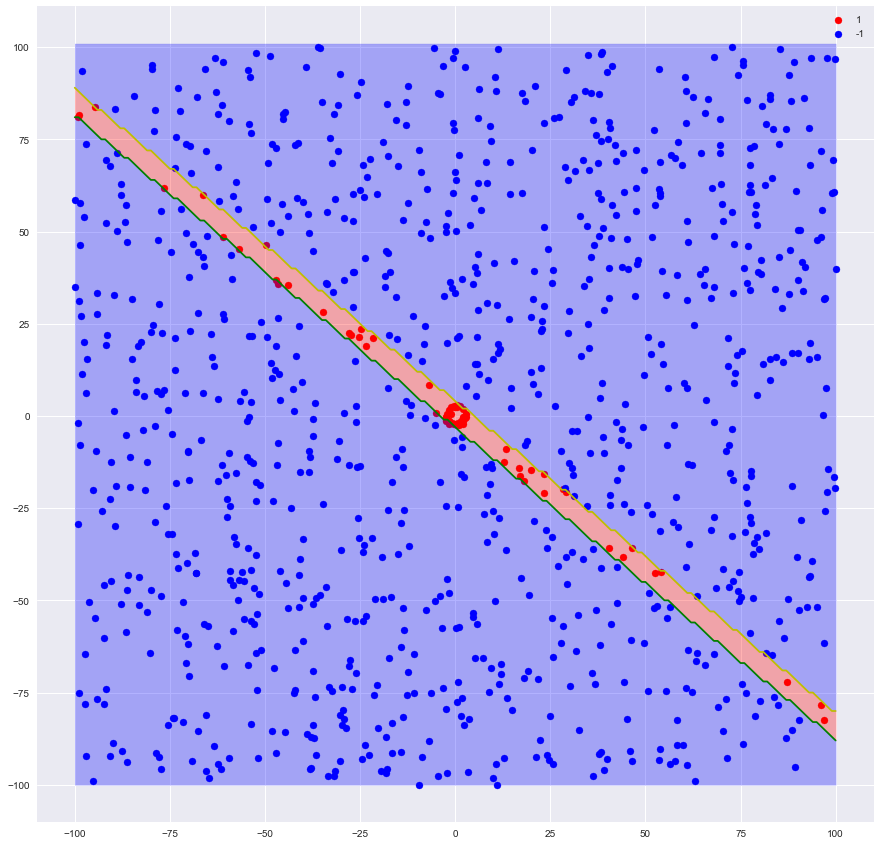

In [367]:
plt.figure(figsize=(15,15))
ad2.plot_graph(data=testB.loc[:,["x","y"]],args1={"c":'r',"label":"1"},args2={"c":'b',"label":"-1"},name="partB_balanced_graph")

In [374]:
trainB = genData.create_B(size=10000)
testB = genData.create_B(seed=testDataSeed,size=10000)

In [399]:

#smaller learning rate to compensate for more data
ad2 = Adaline(seed,bias=0.35,learning_rate=0.0000225,repeats=1000,activationFunction=activationFunction)
performance2 = ad2.fit(trainB.loc[:,["x","y"]], trainB["target"], logRate = 5,verbose=1,precision=10)

Epoch 0
0.020256769620983977
errors: 130
--------
Epoch 5
0.02111082009851453
errors: 134
--------
Epoch 10
0.020736700744910574
errors: 134
--------
Epoch 15
0.0208625953161955
errors: 135
--------
Epoch 20
0.021780115437973403
errors: 135
--------
Epoch 25
0.02137495574478215
errors: 134
--------
Epoch 30
0.0214500783313055
errors: 135
--------
Epoch 35
0.021050422398820424
errors: 132
--------
Epoch 40
0.02066134222070327
errors: 132
--------
Epoch 45
0.02105231202792409
errors: 135
--------
Epoch 50
0.02065739246246263
errors: 133
--------
Epoch 55
0.019075206169031453
errors: 137
--------
Epoch 60
0.020016315028586466
errors: 141
--------
Epoch 65
0.0210157683756235
errors: 125
--------
Epoch 70
0.019882390307262365
errors: 121
--------
Epoch 75
0.020344906926953694
errors: 121
--------
Epoch 80
0.019323408950540345
errors: 116
--------
Epoch 85
0.019339589877009
errors: 117
--------
Epoch 90
0.01913282518093432
errors: 118
--------
Epoch 95
0.021247546156009055
errors: 140
------

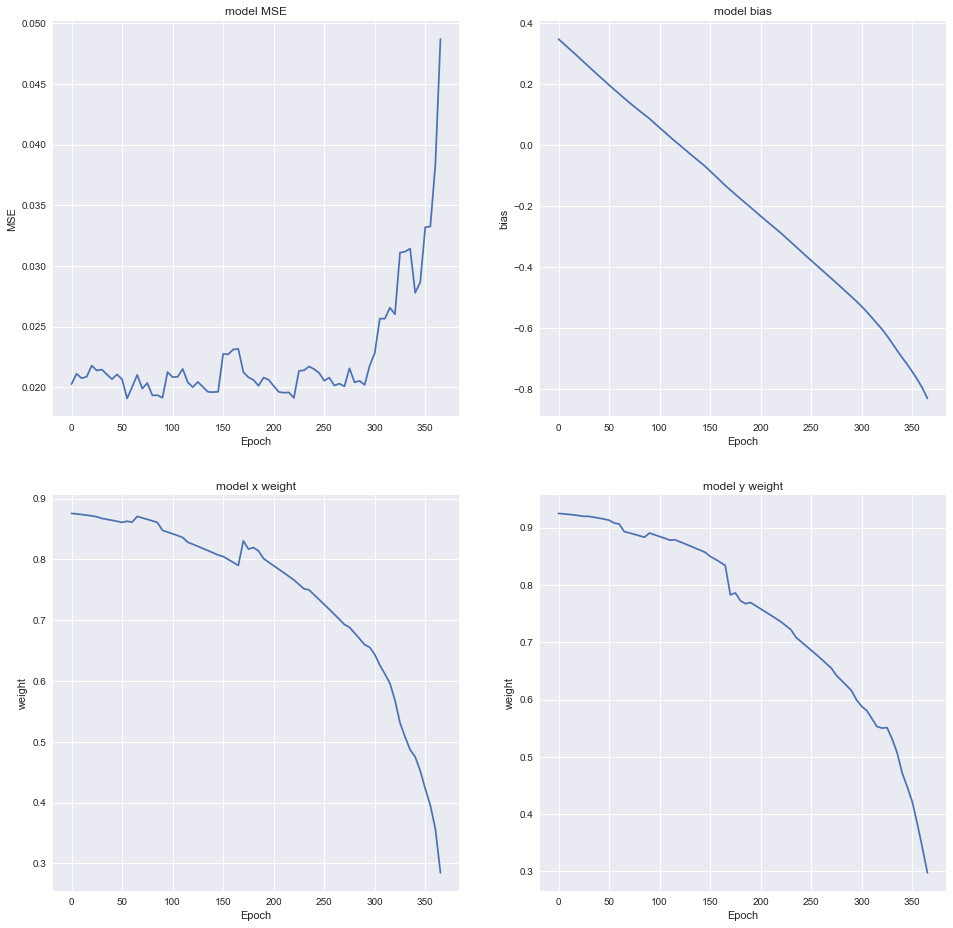

In [400]:
plot_performance(performance=performance2,name="partB_10k_stats")

In [401]:
testB_res = ad2.predict(testB.loc[:,["x","y"]])
accuracy_score(testB["target"],testB_res)

0.9575

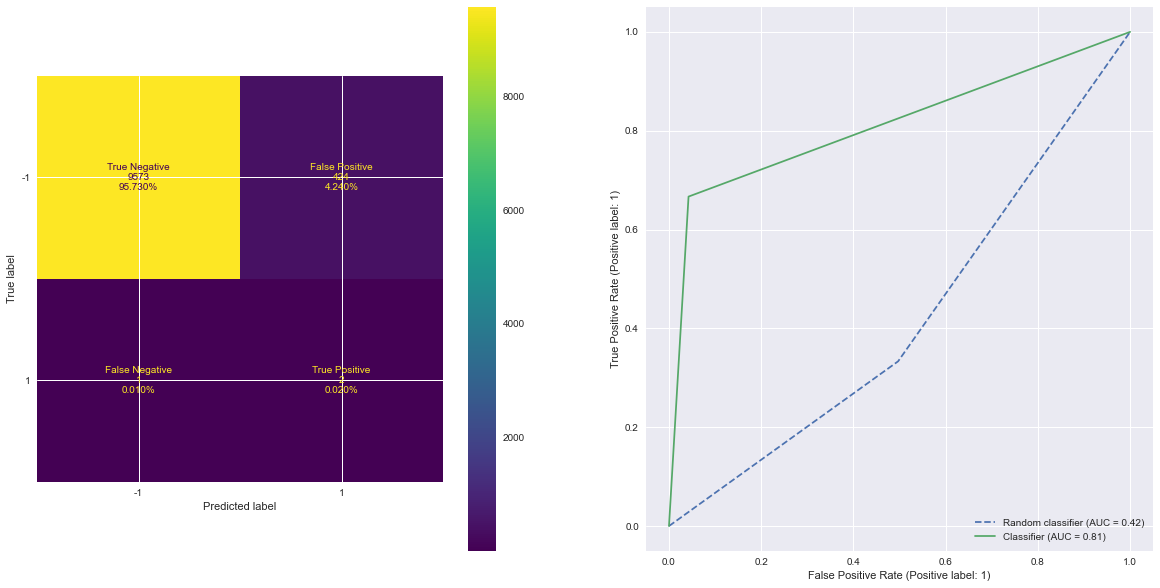

In [402]:
genData.plot_model_results(testB["target"],testB_res,labels=["-1","1"],name="partB_10k_cm_roc")

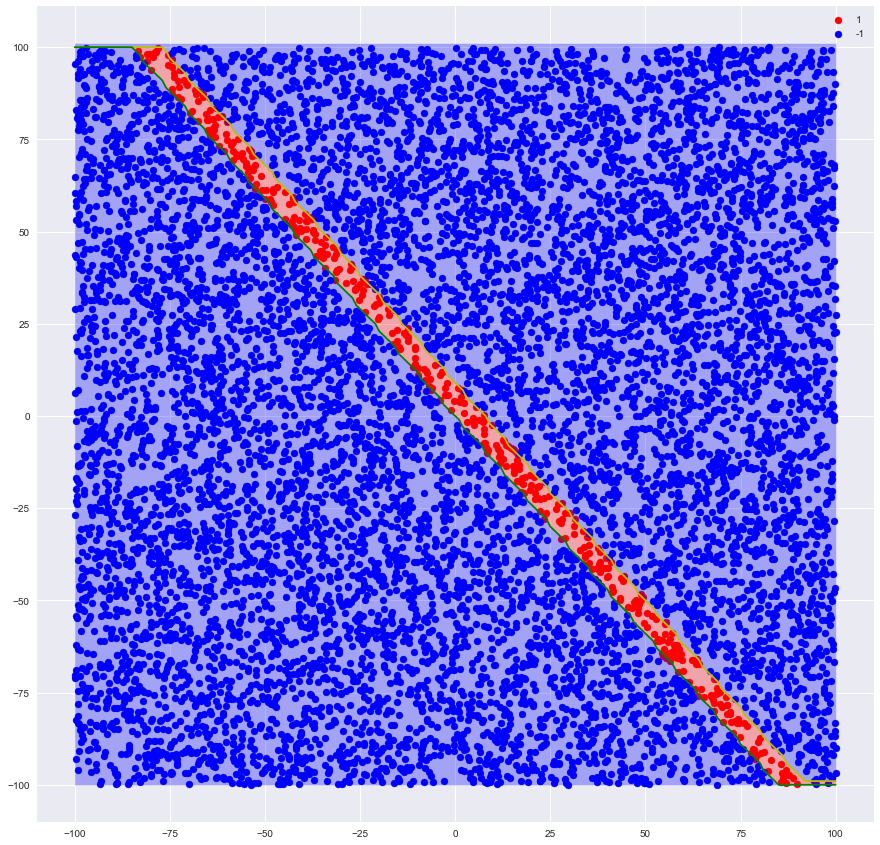

In [403]:
plt.figure(figsize=(15,15))
ad2.plot_graph(data=testB.loc[:,["x","y"]],args1={"c":'r',"label":"1"},args2={"c":'b',"label":"-1"},name="partB_10k_graph")

In [406]:
performance2.tail(30)

,Epoch,bias,MSE,w_0,deltaW_0,w_1,deltaW_1
44,220,-0.288394,0.019117,0.766289,-0.000051,0.735880,0.000057
45,225,-0.303388,0.021342,0.759070,-0.000049,0.728964,0.000055
46,230,-0.318336,0.021393,0.751749,-0.000047,0.721956,0.000052
47,235,-0.333464,0.021707,0.749921,-0.000069,0.708582,0.000076
48,240,-0.348595,0.021489,0.741975,-0.000066,0.701096,0.000074
49,245,-0.363559,0.021171,0.734014,-0.000064,0.693592,0.000071
50,250,-0.378380,0.020531,0.726047,-0.000061,0.686080,0.000068
51,255,-0.393136,0.020789,0.717998,-0.000059,0.678562,0.000065
52,260,-0.407923,0.020141,0.709826,-0.000057,0.670855,0.000063
53,265,-0.422708,0.020293,0.701577,-0.000055,0.662768,0.000061


In [407]:
ad2.weights.shape

(2,)

In [408]:
def calcVal(x,y,p):
    return p["bias"] + x*p["w_0"]+y*p["w_1"]

In [409]:
vals = calcVal(43,23,performance2)
for i in range(len(vals)):
    print(vals[i])

59.280771993900004
59.2118937779
59.136234432399995
59.055003368499996
58.959185359200006
58.8555543139
58.718420703
58.6033012272
58.4858300782
58.3622501257
58.22752397309999
58.176873175599994
58.0606642305
58.1435045322
57.9722338655
57.80184838619999
57.620632029199996
57.4376636403
57.0322551445
56.8275318213
56.62206251479999
56.4142352496
56.1872684639
55.852760342399996
55.6139269003
55.3729748575
55.122504797999994
54.872487043999996
54.621248812599994
54.3618977922
54.08016539810001
53.7437394234
53.39100396239999
53.0265650719
53.57459082
53.054323317999994
52.8381231095
52.4651344168
51.95730067390001
51.559472341200006
51.1683156729
50.7806651282
50.393483437200004
49.9905767874
49.5872963685
49.1027768759
48.6118561006
48.2105394986
47.681526176700004
47.1516751927
46.6214629355
46.0876904238
45.5442524333
44.988757033199995
44.4208935116
43.9157942592
43.2977440207
42.673019159800006
42.0271343694
41.4542692979
40.6785626218
39.7434507925
38.7858176509
37.77991684030000